In [1]:

import sys
import pandas as pd
sys.path.insert(0,'..')
sys.path.insert(0,'../..')
from utils import MetaEvaluator
import matplotlib.pyplot as plt

In [2]:
FINAL_FEATURE_FRACTION = {'powersupply': 50, 'airlines': 65, 'electricity': 15, 'rialto': 10}

# Electricity

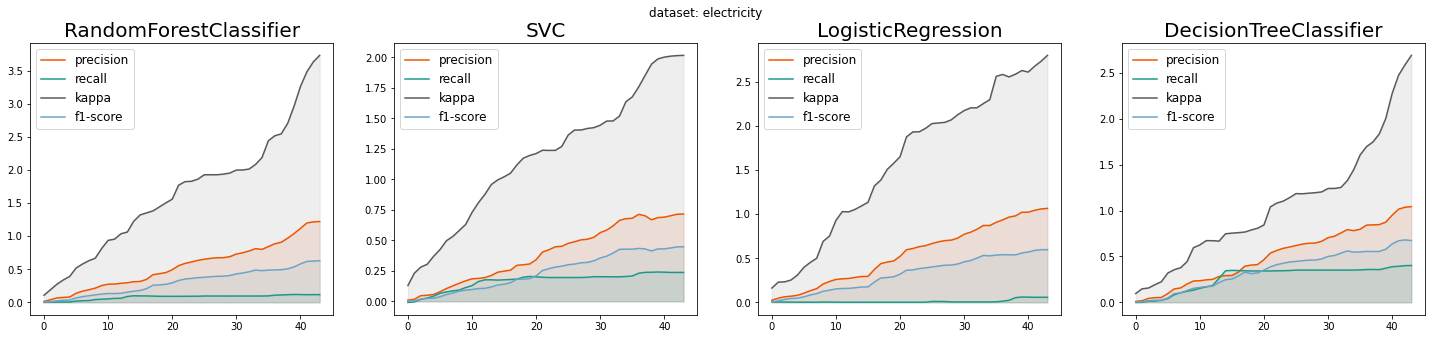

In [3]:
elec_eval = MetaEvaluator(dataset_name="electricity", feature_fraction=FINAL_FEATURE_FRACTION["electricity"]).fit()
elec_eval.plot_gain()

### Compare with original MtL

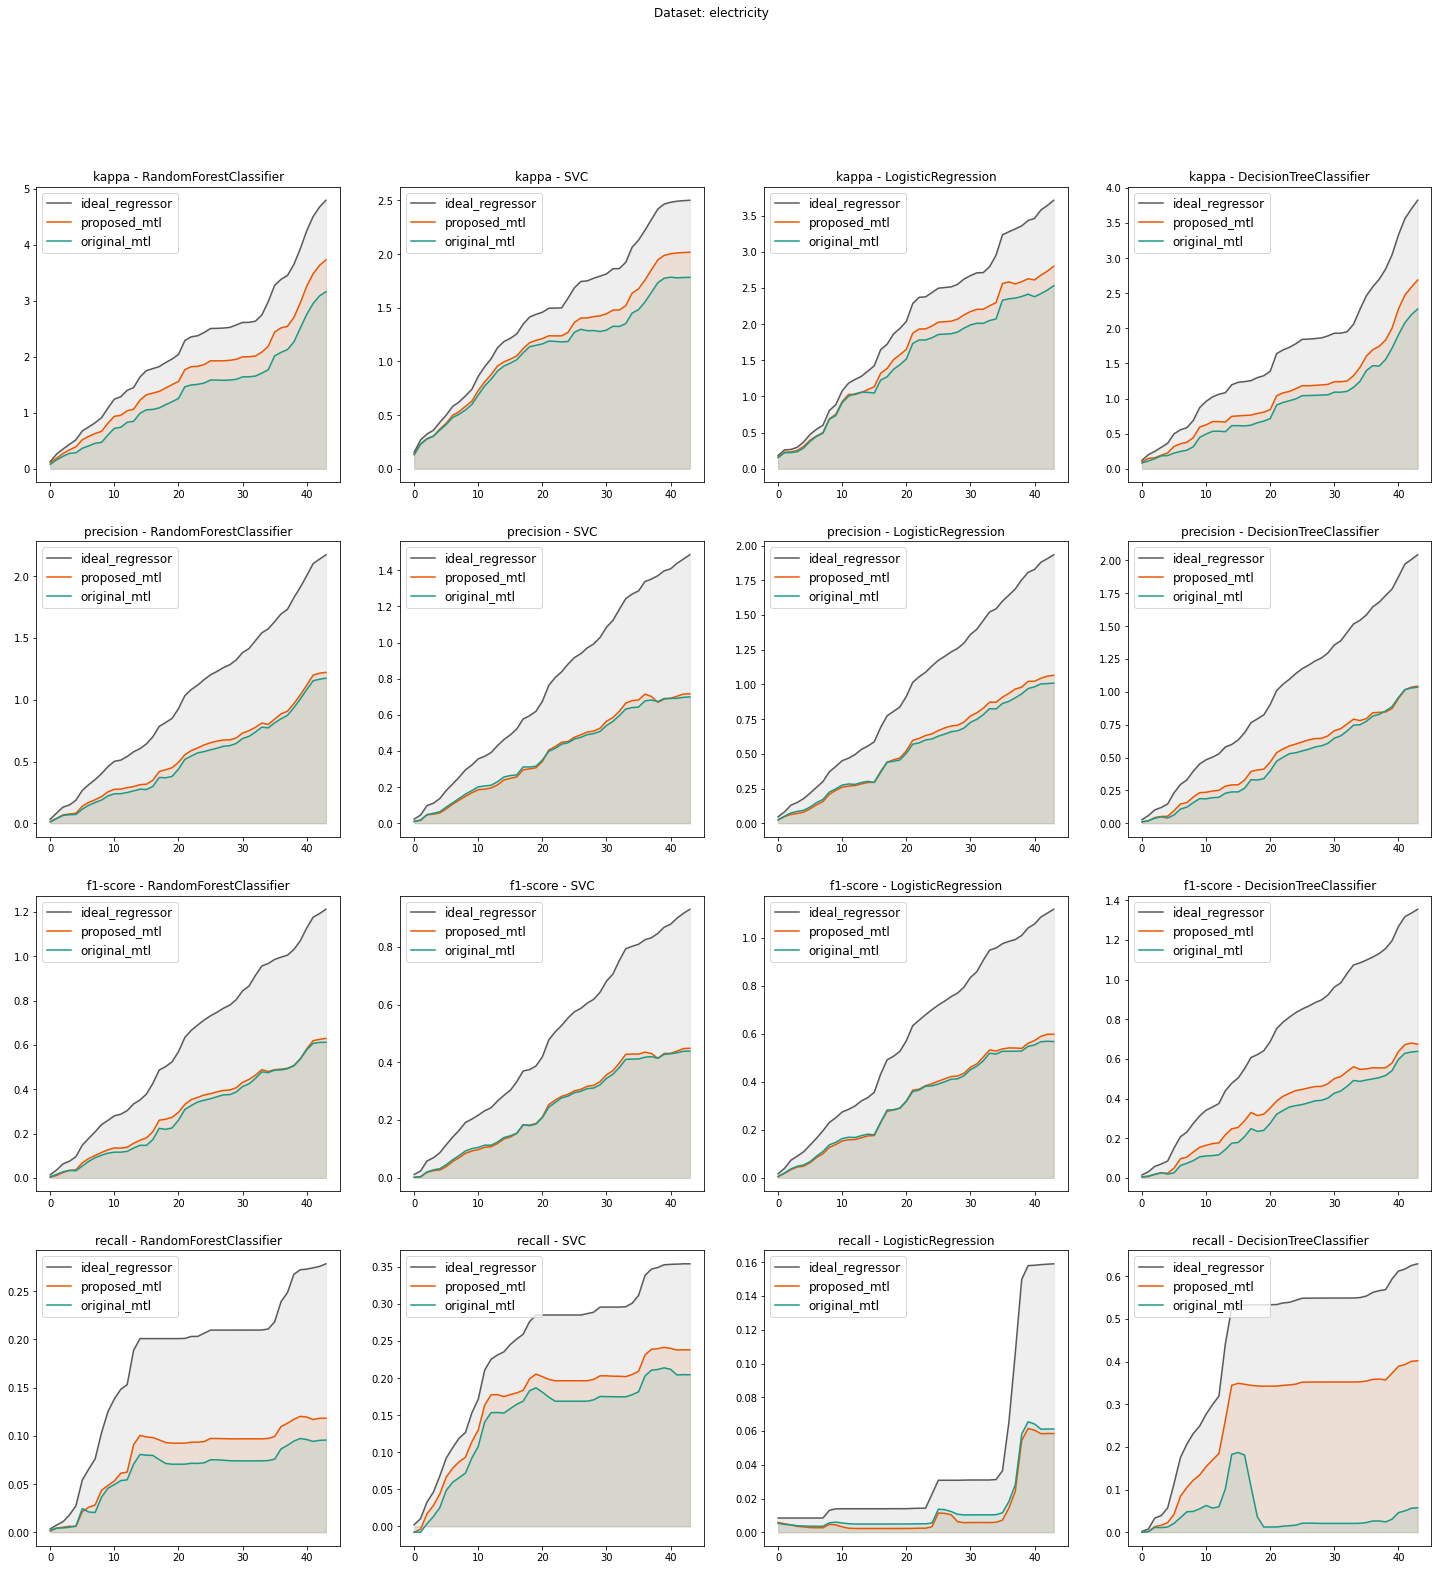

In [4]:
plt.figure(figsize=(25, 25))
plt.suptitle("Dataset: electricity")

elec_eval.plot_original_vs_proposed_mtl_gain(metric="kappa", subplot_index=1)
elec_eval.plot_original_vs_proposed_mtl_gain(metric="precision", subplot_index=5)
elec_eval.plot_original_vs_proposed_mtl_gain(metric="f1-score", subplot_index=9)
elec_eval.plot_original_vs_proposed_mtl_gain(metric="recall", subplot_index=13)

# Rialto

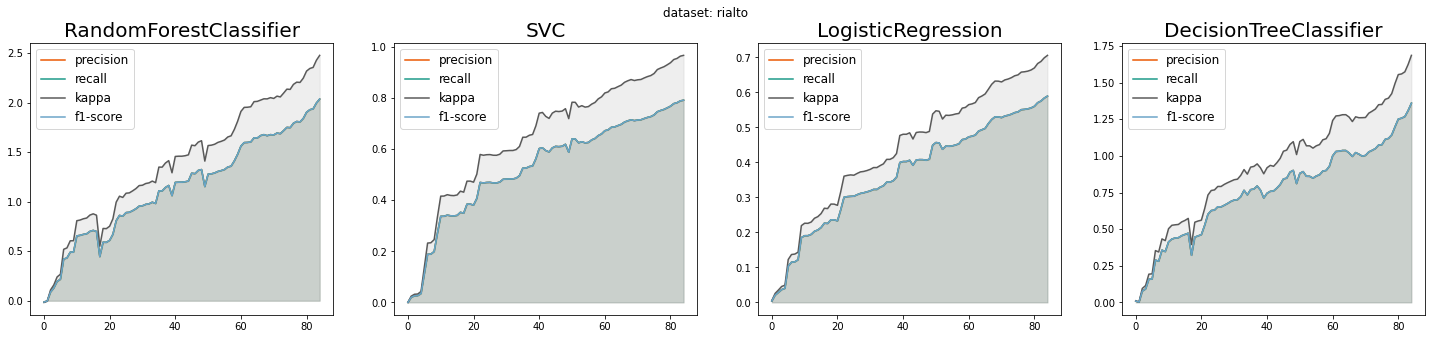

In [5]:
rialto_eval = MetaEvaluator(dataset_name="rialto", feature_fraction=FINAL_FEATURE_FRACTION["rialto"]).fit()
rialto_eval.plot_gain()

### Compare with original MtL

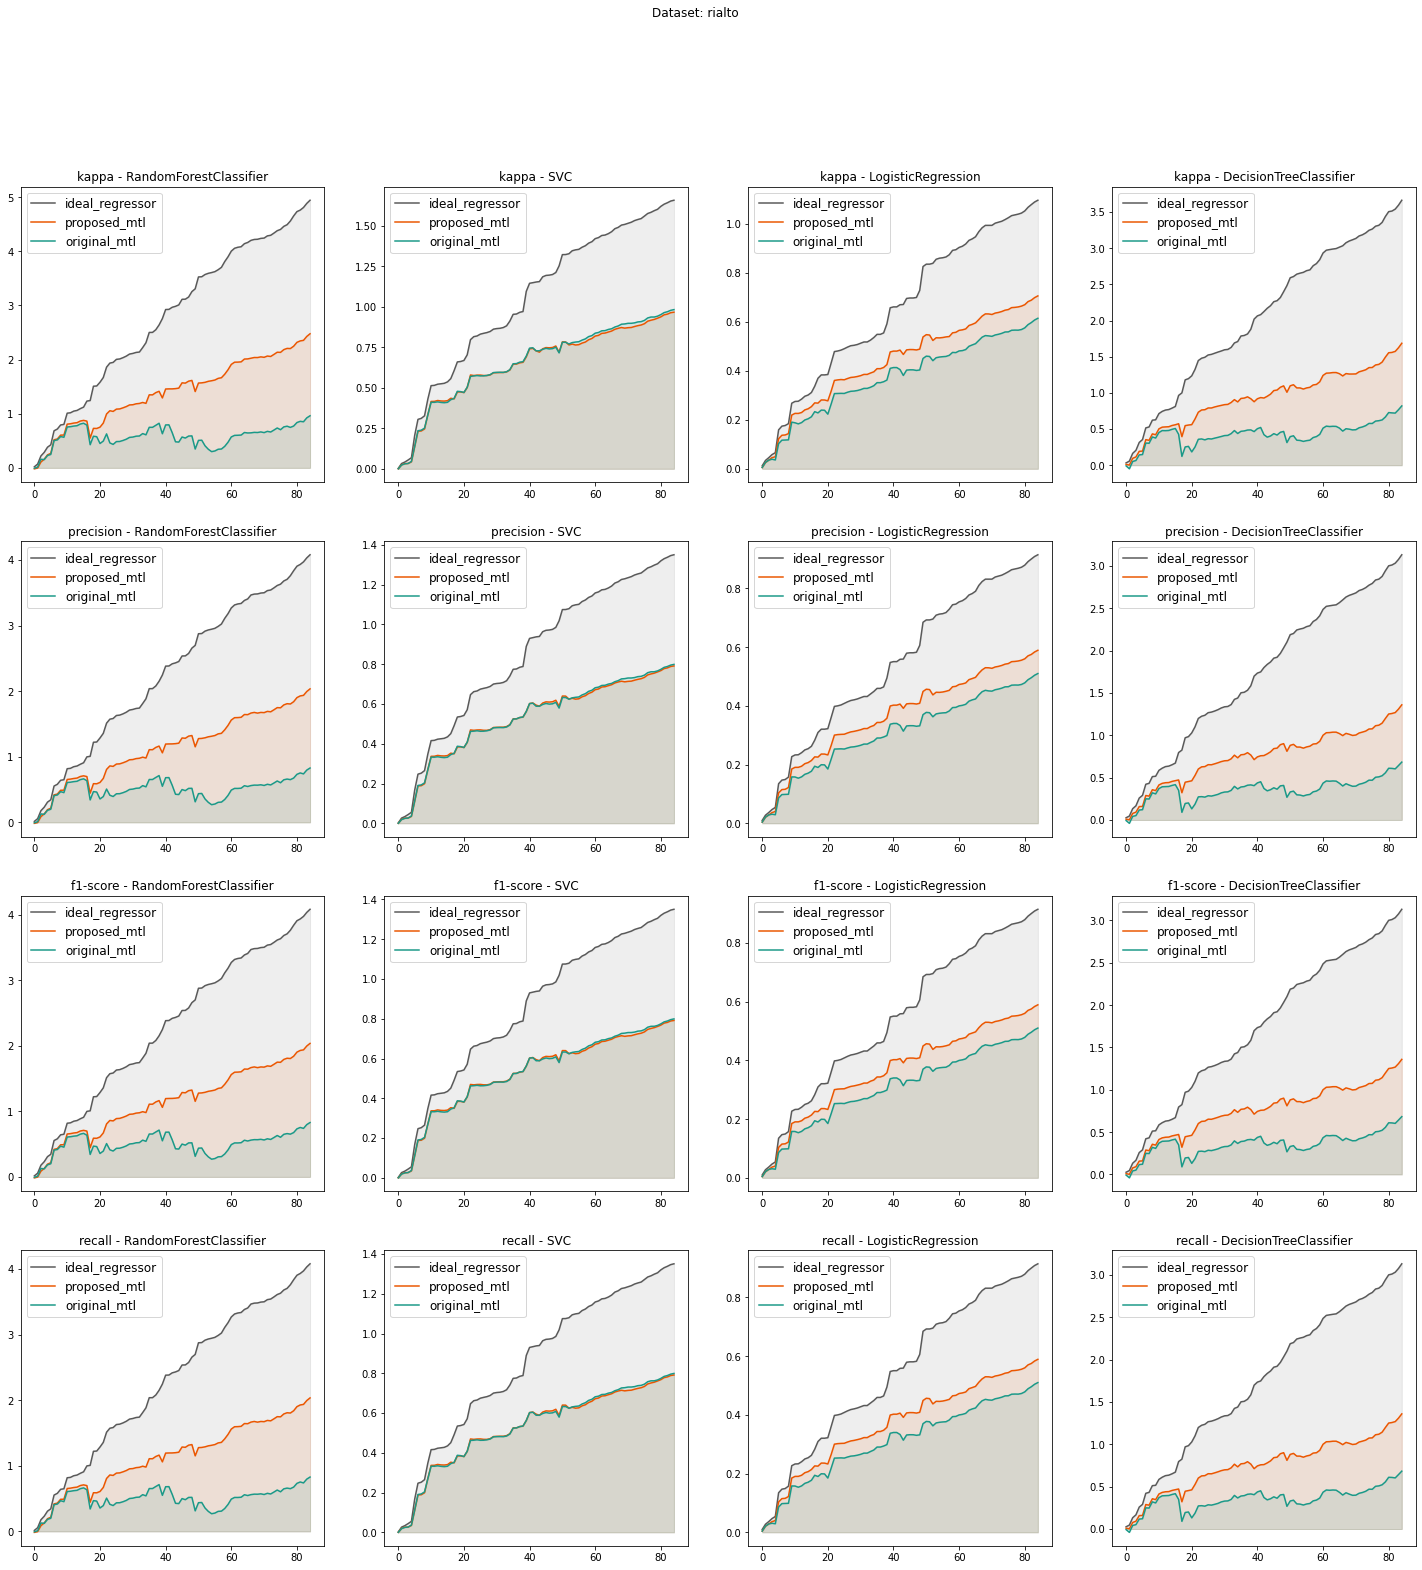

In [6]:
plt.figure(figsize=(25, 25))
plt.suptitle("Dataset: rialto")

rialto_eval.plot_original_vs_proposed_mtl_gain(metric="kappa", subplot_index=1)
rialto_eval.plot_original_vs_proposed_mtl_gain(metric="precision", subplot_index=5)
rialto_eval.plot_original_vs_proposed_mtl_gain(metric="f1-score", subplot_index=9)
rialto_eval.plot_original_vs_proposed_mtl_gain(metric="recall", subplot_index=13)

# Powersupply

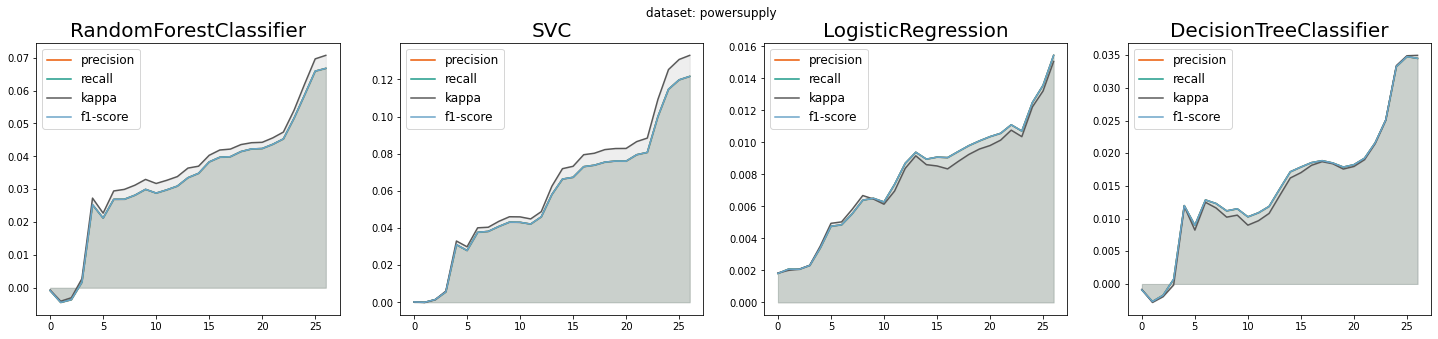

In [7]:
powersupply_eval = MetaEvaluator(dataset_name="powersupply", feature_fraction=FINAL_FEATURE_FRACTION["powersupply"]).fit()
powersupply_eval.plot_gain()

### Compare with original MtL

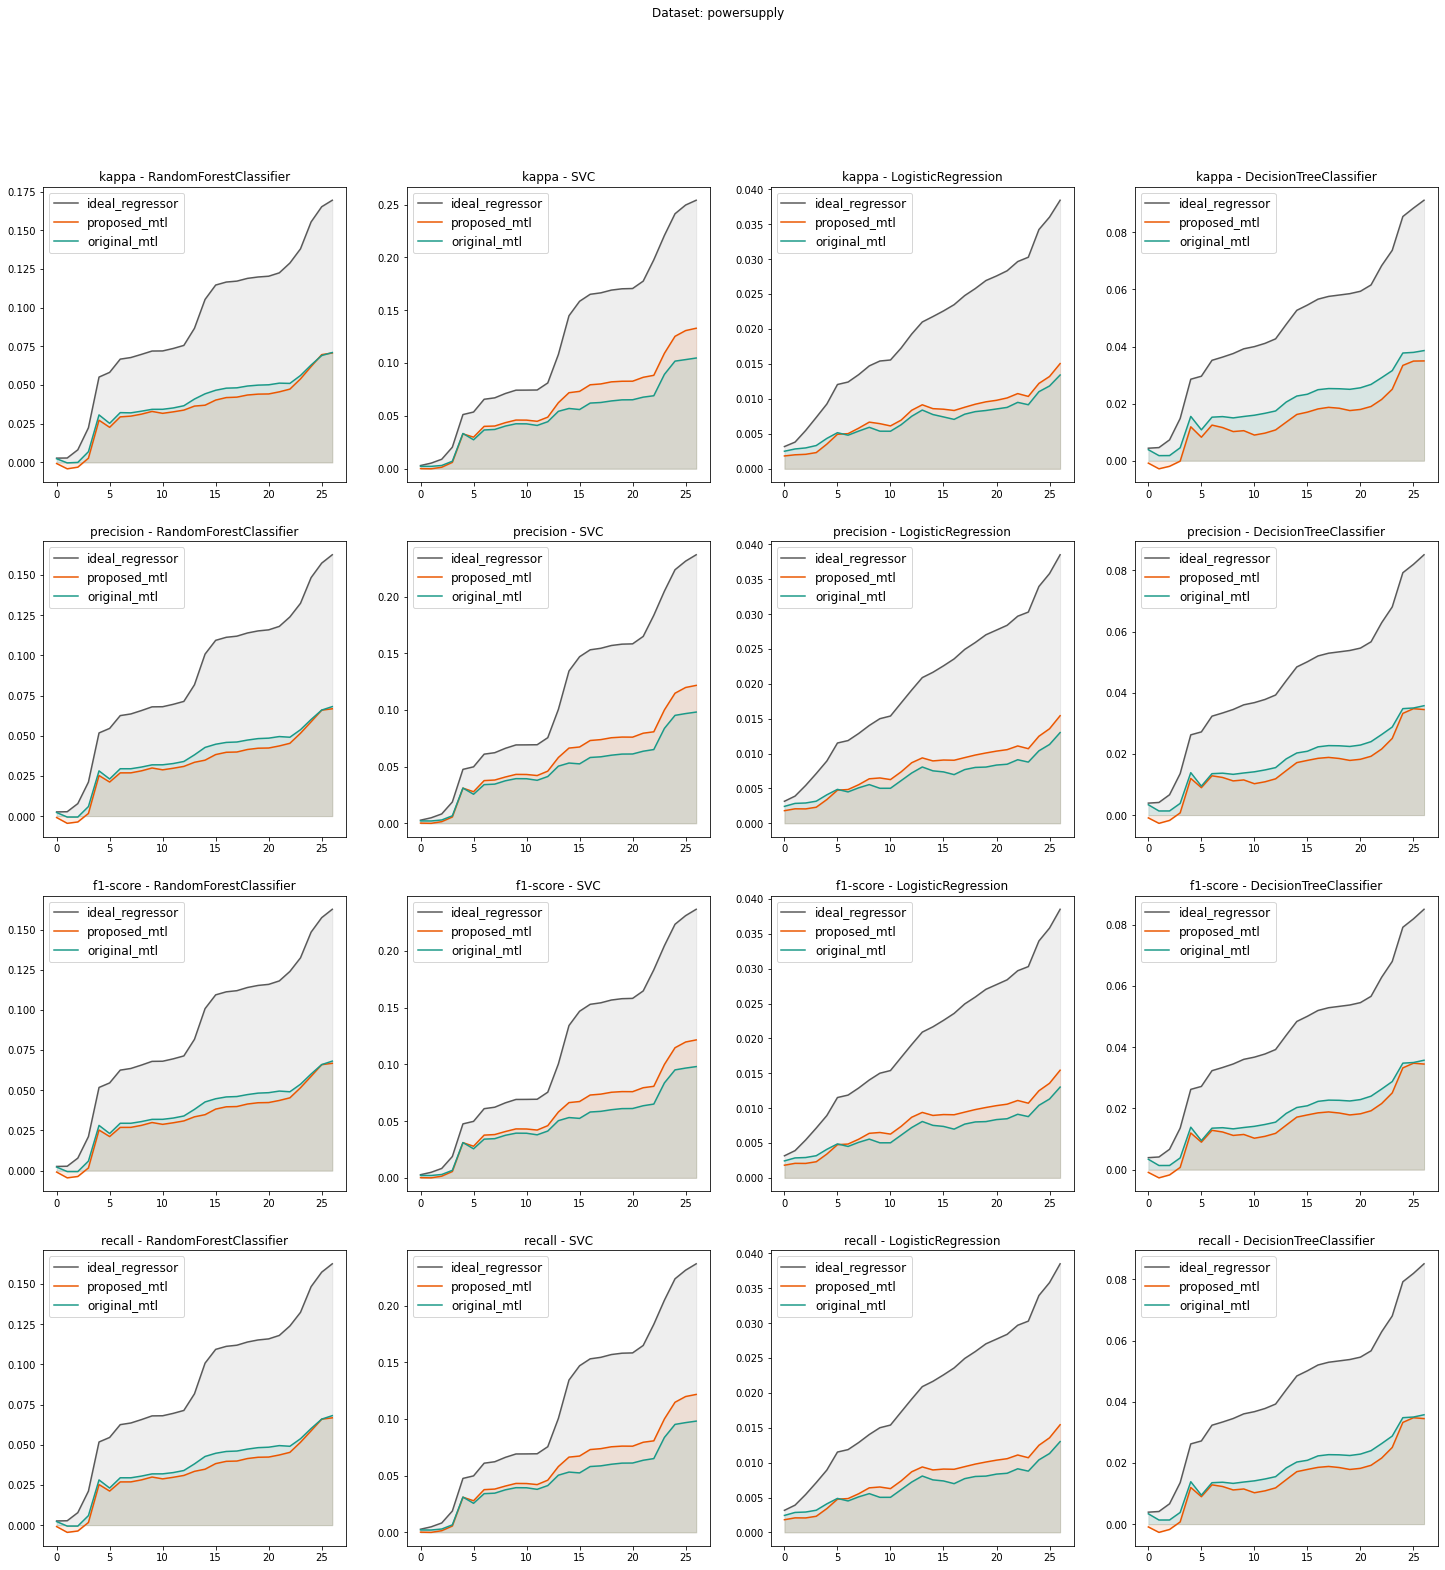

In [8]:
plt.figure(figsize=(25, 25))
plt.suptitle("Dataset: powersupply")

powersupply_eval.plot_original_vs_proposed_mtl_gain(metric="kappa", subplot_index=1)
powersupply_eval.plot_original_vs_proposed_mtl_gain(metric="precision", subplot_index=5)
powersupply_eval.plot_original_vs_proposed_mtl_gain(metric="f1-score", subplot_index=9)
powersupply_eval.plot_original_vs_proposed_mtl_gain(metric="recall", subplot_index=13)

# Airlines

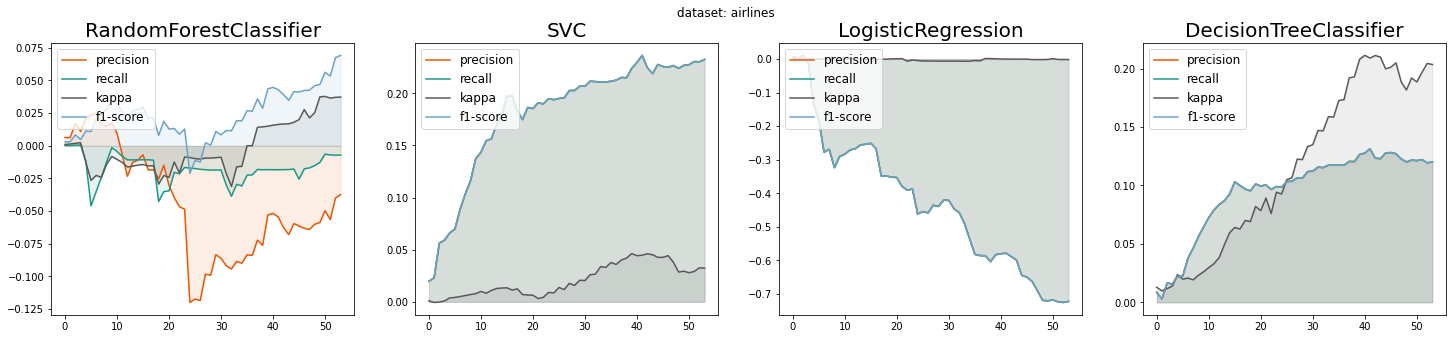

In [9]:
airlines_eval = MetaEvaluator(dataset_name="airlines", feature_fraction=FINAL_FEATURE_FRACTION["airlines"]).fit()
airlines_eval.plot_gain()

## Compare with original MtL

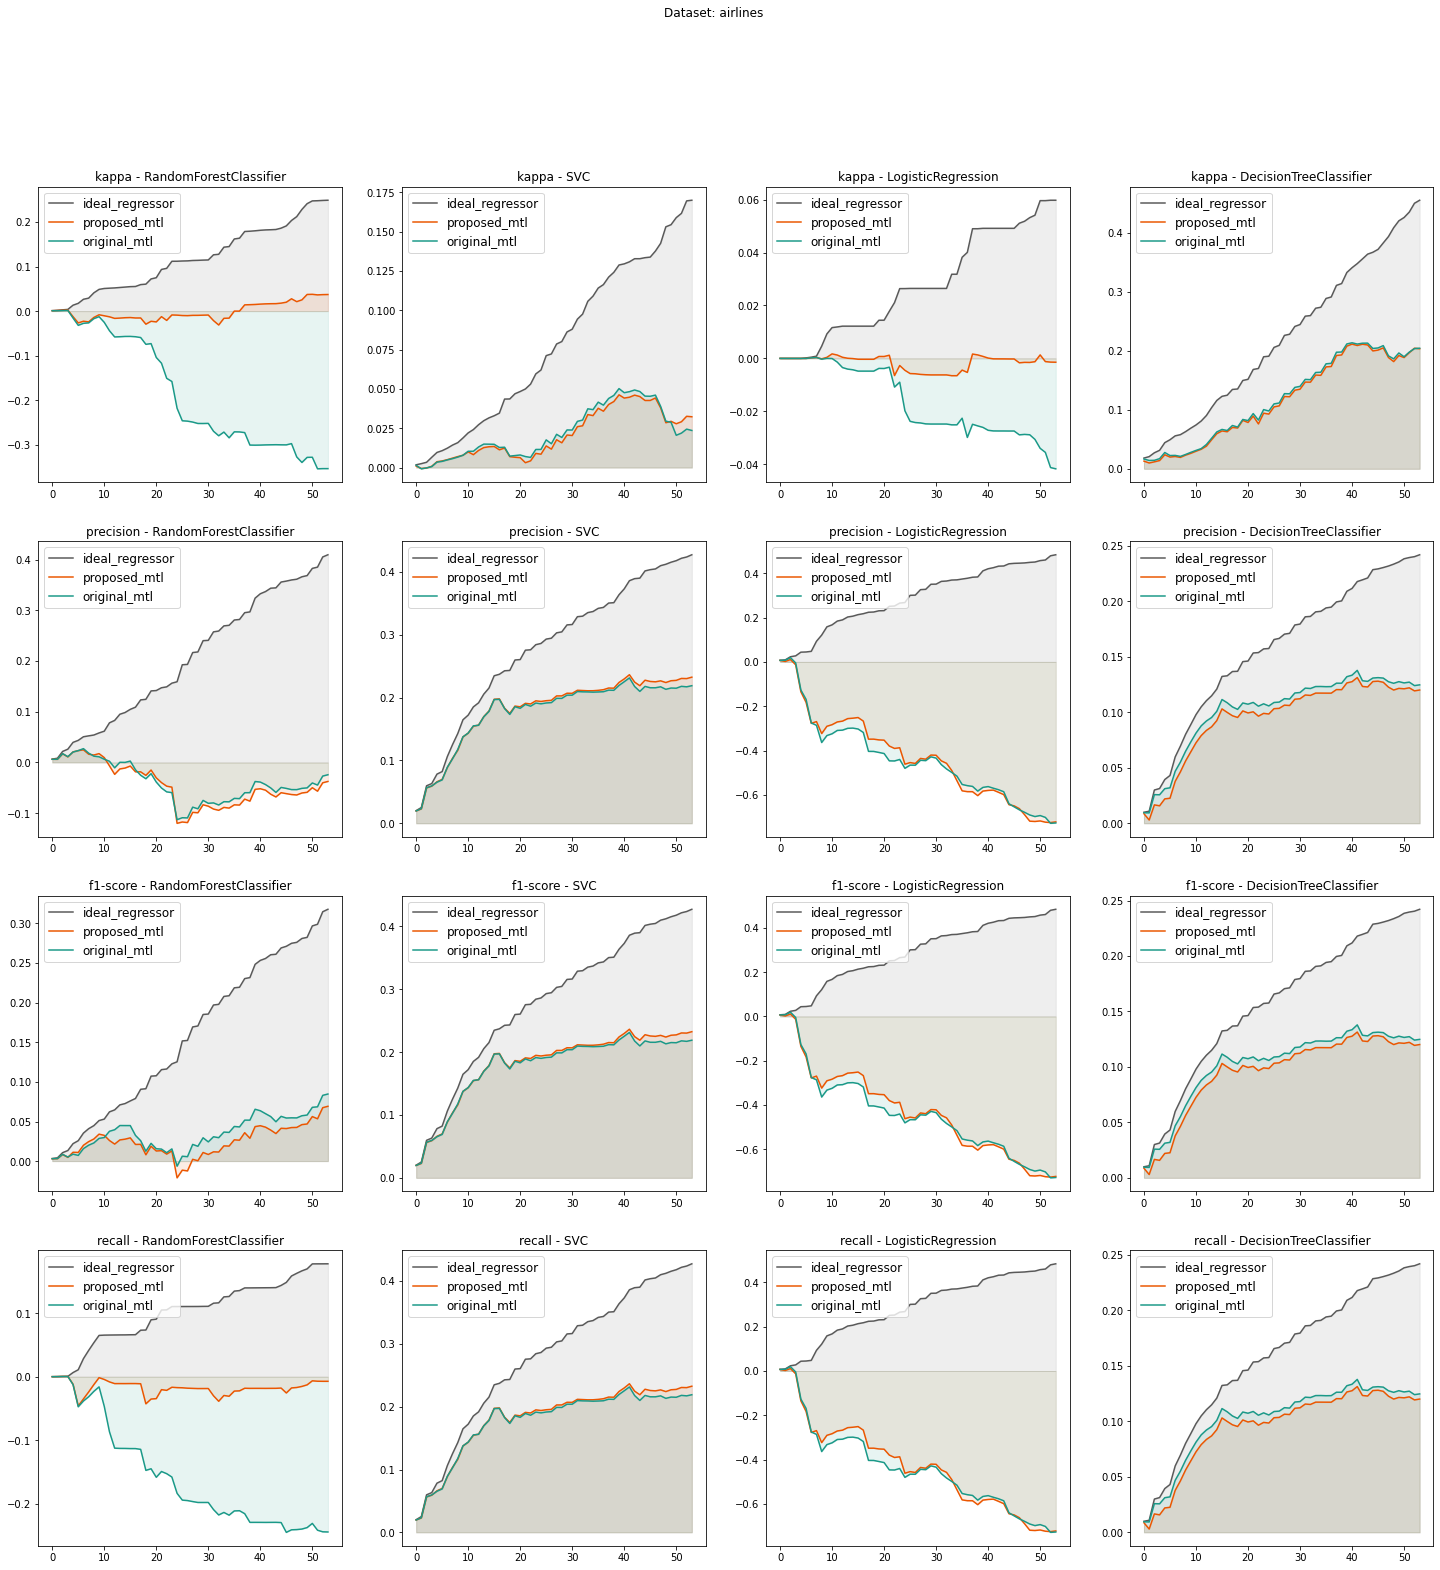

In [10]:
plt.figure(figsize=(25, 25))
plt.suptitle("Dataset: airlines")

airlines_eval.plot_original_vs_proposed_mtl_gain(metric="kappa", subplot_index=1)
airlines_eval.plot_original_vs_proposed_mtl_gain(metric="precision", subplot_index=5)
airlines_eval.plot_original_vs_proposed_mtl_gain(metric="f1-score", subplot_index=9)
airlines_eval.plot_original_vs_proposed_mtl_gain(metric="recall", subplot_index=13)

# Summarized results

In [88]:

mean_results = []

for evaluator in (elec_eval, powersupply_eval, airlines_eval, rialto_eval):
    for model in evaluator.metrics.keys():
        for metric in evaluator.metrics[model]:
            df = evaluator.results[model]
            mean_results.append({
                "dataset": evaluator.dataset_name,
                "model": model,
                "metric": metric,
                "baseline": df[f"{metric}_mse_baseline"].mean(),
                "original_mtl": df[f"{metric}_original_mtl_mse"].mean(),
                "proposed_mtl": df[f"{metric}_proposed_mtl_mse"].mean(),
            })

mean_results_df = pd.DataFrame(mean_results)
mean_results_df.head()

,dataset,model,metric,baseline,original_mtl,proposed_mtl
0,electricity,RandomForestClassifier,precision,0.049415,0.022709,0.021641
1,electricity,RandomForestClassifier,recall,0.006326,0.004152,0.003637
2,electricity,RandomForestClassifier,kappa,0.108935,0.037119,0.024179
3,electricity,RandomForestClassifier,f1-score,0.027545,0.013636,0.013242
4,electricity,SVC,precision,0.033757,0.017862,0.017476


In [99]:
mean_results_df["increase_vs_baseline"] = (mean_results_df["baseline"] - mean_results_df["proposed_mtl"])/mean_results_df["baseline"]
mean_results_df["increase_vs_original_mtl"] = (mean_results_df["original_mtl"] - mean_results_df["proposed_mtl"])/mean_results_df["original_mtl"]
mean_results_df.head()

,dataset,model,metric,baseline,original_mtl,proposed_mtl,increase_vs_baseline,increase_vs_original_mtl
0,electricity,RandomForestClassifier,precision,0.049415,0.022709,0.021641,0.562045,0.046998
1,electricity,RandomForestClassifier,recall,0.006326,0.004152,0.003637,0.425115,0.123993
2,electricity,RandomForestClassifier,kappa,0.108935,0.037119,0.024179,0.778040,0.348611
3,electricity,RandomForestClassifier,f1-score,0.027545,0.013636,0.013242,0.519259,0.028891
4,electricity,SVC,precision,0.033757,0.017862,0.017476,0.482287,0.021580


In [103]:
model_reducer_dict = {
    "RandomForestClassifier": "RF",
    "DecisionTreeClassifier": "DT",
    "LogisticRegression": "LR",
    "SVC": "SVC",
}
def reduce_model_name(row):
    return model_reducer_dict[row]

mean_results_df["model"] = mean_results_df["model"].apply(reduce_model_name)
mean_results_df.head()

,dataset,model,metric,baseline,original_mtl,proposed_mtl,increase_vs_baseline,increase_vs_original_mtl
0,electricity,RF,precision,0.049415,0.022709,0.021641,0.562045,0.046998
1,electricity,RF,recall,0.006326,0.004152,0.003637,0.425115,0.123993
2,electricity,RF,kappa,0.108935,0.037119,0.024179,0.778040,0.348611
3,electricity,RF,f1-score,0.027545,0.013636,0.013242,0.519259,0.028891
4,electricity,SVC,precision,0.033757,0.017862,0.017476,0.482287,0.021580


In [91]:
print(f"increase_vs_baseline: {mean_results_df['increase_vs_baseline'].mean() * 100}")
print(f"increase_vs_original_mtl: {mean_results_df['increase_vs_original_mtl'].mean() * 100}")

increase_vs_baseline: 38.07370210229208
increase_vs_original_mtl: 12.861552011861871


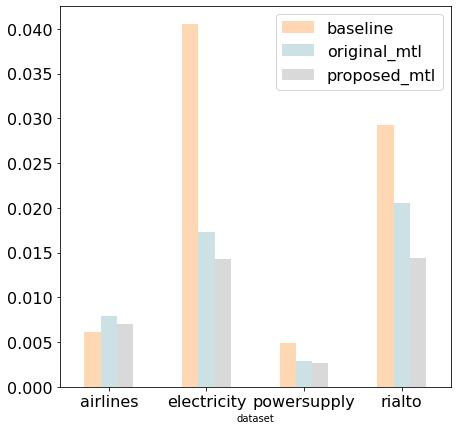

In [106]:
COLORS = [
    "#ffd7b3", # orange
    "#cce1e4", # green
    "#d9d9d9", # grey
    ]

def plot_mean_mse(group_by='dataset'):
    grouped_df = mean_results_df.groupby([group_by]).mean()
    cols_2_plot = ["baseline", "original_mtl", "proposed_mtl"]
    grouped_df[cols_2_plot].plot.bar(figsize=(7,7), fontsize=16, color=COLORS, rot=0).legend(loc='best', prop={'size': 16})

plot_mean_mse()

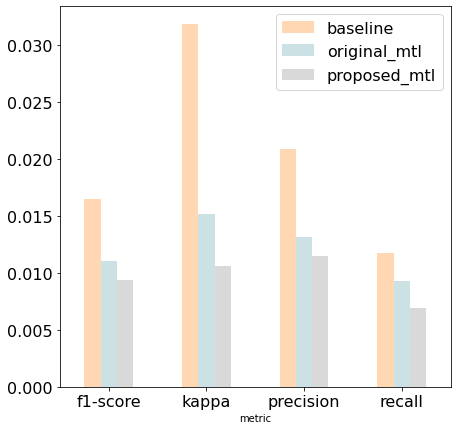

In [107]:
plot_mean_mse("metric")

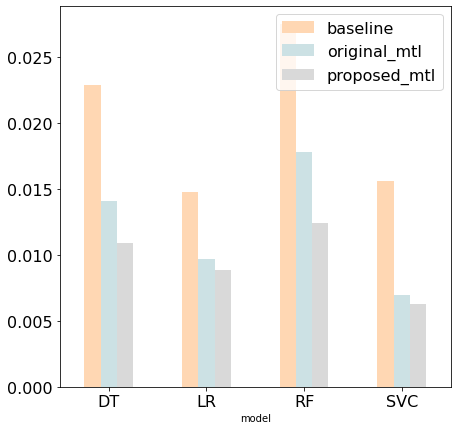

In [108]:
plot_mean_mse("model")

# Check percentage of ideal regressor

In [126]:
BASE_MODELS = [
    "RandomForestClassifier",
    "SVC",
    "LogisticRegression",
    "DecisionTreeClassifier"
]

def get_final_gain(base_model, plot_col, metric="recall"):
    results_df = elec_eval.results[base_model]
    if plot_col == "ideal_regressor":
        results_df[f"{metric}_ideal_regressor_mse"] = 0
    regressor_error = results_df[f"{metric}_{plot_col}_mse"]
    baseline_error = results_df[f"{metric}_mse_baseline"]
    proposed_mtl_gain = baseline_error - regressor_error
    y = proposed_mtl_gain.cumsum()
    return list(y)[-1]

for base_model in BASE_MODELS:
    original = get_final_gain(base_model, "original_mtl")
    proposed = get_final_gain(base_model, "proposed_mtl")
    ideal = get_final_gain(base_model, "ideal_regressor")
    print(f"BASE_MODEL: {base_model} -> original: {original/ideal}, proposed: {proposed/ideal}")
        

BASE_MODEL: RandomForestClassifier -> original: 0.34374385605448227, proposed: 0.42511524015972724
BASE_MODEL: SVC -> original: 0.5776198024582441, proposed: 0.6725186468047609
BASE_MODEL: LogisticRegression -> original: 0.38486981500987594, proposed: 0.36818468871484966
BASE_MODEL: DecisionTreeClassifier -> original: 0.09105588268211448, proposed: 0.6387059116322107
